##  Stereo Disparity Project

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import tensorflow as tf
from scipy import signal



In [2]:
root_path = ''
image_left= cv2.imread(os.path.join(root_path, "2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg"),cv2.IMREAD_GRAYSCALE).astype(np.float32)
image_right= cv2.imread(os.path.join(root_path, "2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg"),cv2.IMREAD_GRAYSCALE).astype(np.float32)
gt_disparity = cv2.imread(os.path.join(root_path, "2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png"),-1).astype(np.float32)/256

bsize = (3, 3)
image_left_blur = cv2.GaussianBlur(image_left, bsize, 0, 0)
image_right_blur = cv2.GaussianBlur(image_right, bsize, 0, 0)

In [3]:
def normalise(image):
    h,l=image.shape
    average=np.sum(image)/(h*l)
    return (image-average)/average

In [4]:
def sharpen(image):
    sharpkernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    return cv2.filter2D(image, -1,sharpkernel)

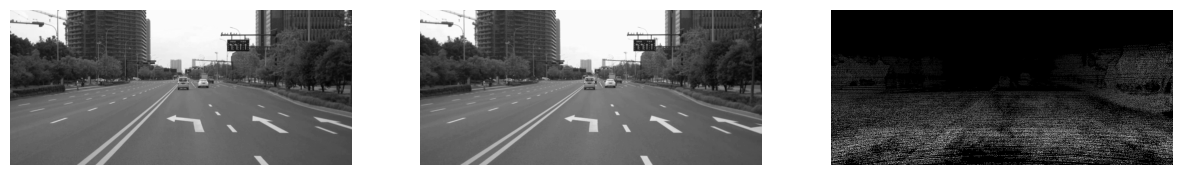

In [5]:
plt.subplots(figsize = (15,15))
plt.subplot(1,3,1)
plt.imshow(image_left,cmap = 'gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_right,cmap = 'gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(gt_disparity,cmap = 'gray')
plt.axis('off')
plt.show()

## Basci stereo block matching with SAD,SSD and NCC

In [12]:
def BM_disparity(BLOCK_SIZE,image_left,image_right,search_length,similarity_metric):
    padding_size = math.floor(BLOCK_SIZE/2)
    image_left_padded = cv2.copyMakeBorder(src=image_left, top=padding_size, bottom=padding_size, left=padding_size, right=padding_size, borderType=cv2.BORDER_CONSTANT) 
    image_right_padded = cv2.copyMakeBorder(src=image_right, top=padding_size, bottom=padding_size, left=padding_size, right=padding_size, borderType=cv2.BORDER_CONSTANT) 
    rows, cols = image_left.shape
    disparity_image = np.zeros((rows,cols))
    for row_left in tqdm(range(image_left.shape[0])):
        for column_left in range(image_left.shape[1]):
            left_window= image_left_padded[row_left:row_left+BLOCK_SIZE,column_left:column_left+BLOCK_SIZE]
            metric_per_row= []
            for column_right in range(column_left - search_length,column_left):
                if column_left - search_length <= 0:
                    column_right = 0  
                right_window = image_right_padded[row_left:row_left+BLOCK_SIZE,column_right:column_right+BLOCK_SIZE]
                if similarity_metric == 'SSD':
                    metric_per_column = np.sum((left_window - right_window)**2)
                    metric_per_row.append([metric_per_column,column_right])
                elif similarity_metric == 'SAD':
                    metric_per_column = np.sum(abs(left_window - right_window))
                    metric_per_row.append([metric_per_column,column_right])
                #The image patch needs to be normalized first
                elif similarity_metric == 'NCC':
                    sum_windows = np.sum(left_window*right_window)
                    left_norm = np.linalg.norm(left_window)
                    right_norm = np.linalg.norm(right_window)
                    metric_per_column = sum_windows / (left_norm*right_norm)
                    metric_per_row.append([metric_per_column,column_right])
                # elif similarity_metric == 'RMS':
                #     metric_per_column = np.sqrt(np.sum(((left_window - right_window)**2))/left_window.shape[0])
                #     metric_per_row.append([metric_per_column,column_right])
            if similarity_metric == 'NCC':
                metric_per_row.sort(key = lambda x: x[0],reverse= True)
                disparity_image[row_left][column_left] = np.abs(column_left - metric_per_row[0][1])
            else:
                metric_per_row.sort(key = lambda x: x[0])
                disparity_image[row_left][column_left] = np.abs(column_left - metric_per_row[0][1])
    return disparity_image

def rms_error(disparity_image,gt_disparity):
    rms_non_divide = np.sum(np.square(disparity_image - gt_disparity))
    non_zeros = np.count_nonzero(gt_disparity)
    zeros = np.count_nonzero(gt_disparity == 0)
    total_rms = math.sqrt(rms_non_divide/non_zeros)
    image_error = np.abs(disparity_image - gt_disparity)
    fraction_four = (np.count_nonzero(image_error < 4)- zeros) / non_zeros
    fraction_two = (np.count_nonzero(image_error < 2)- zeros) / non_zeros
    fraction_one = (np.count_nonzero(image_error < 1)- zeros) / non_zeros
    fraction_05 = (np.count_nonzero(image_error < 0.5)- zeros) / non_zeros
    fraction_025 = (np.count_nonzero(image_error < 0.25)- zeros) / non_zeros
    return total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025

def same_mask_as_gt(disparity_image,gt_disparity):
    # same mask
    zero=np.where(gt_disparity==0)
    disparity_image[zero]=0
    return disparity_image

In [184]:
BLOCK_SIZE = 19
SEARCH_LENGTH = 70

## SSD

100%|██████████| 400/400 [03:16<00:00,  2.03it/s]


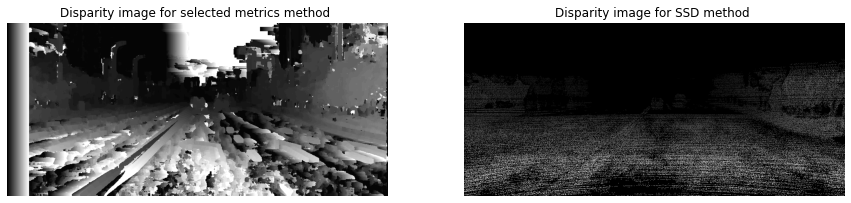

total_rms 17.500975248790034
fraction_four 0.5636592587550624
fraction_two 0.4755811183337304
fraction_one 0.35353775992921077
fraction 0.5 0.21873191981758158
fraction 0.25 0.12145344813894655


In [8]:
similarity_metric = 'SSD'

disparity_image = BM_disparity(BLOCK_SIZE,image_left,image_right,SEARCH_LENGTH,similarity_metric)

plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SSD method ')
plt.axis('off')
plt.show()


disparity_image = same_mask_as_gt(disparity_image,gt_disparity)
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

## SSD (preprocessed image)

100%|██████████| 400/400 [03:14<00:00,  2.05it/s]


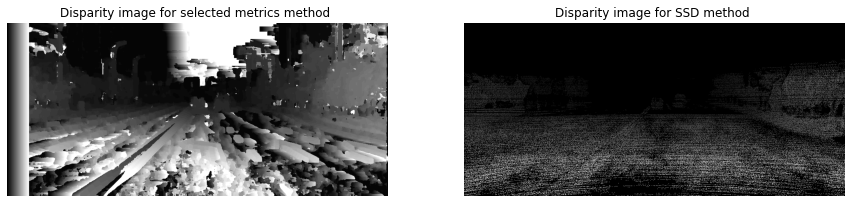

total_rms 44.73120436776677
fraction_four -1.697931910742039
fraction_two -2.0533074680370738
fraction_one -2.6480164267320108
fraction 0.5 -2.7868495388489944
fraction 0.25 -2.8804070380832454


In [9]:
similarity_metric = 'SSD'

disparity_image = BM_disparity(BLOCK_SIZE,image_left_blur,image_right_blur,SEARCH_LENGTH,similarity_metric)

plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SSD method ')
plt.axis('off')
plt.show()



total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

## SAD (Not Normalized image)

100%|██████████| 400/400 [00:58<00:00,  6.88it/s]


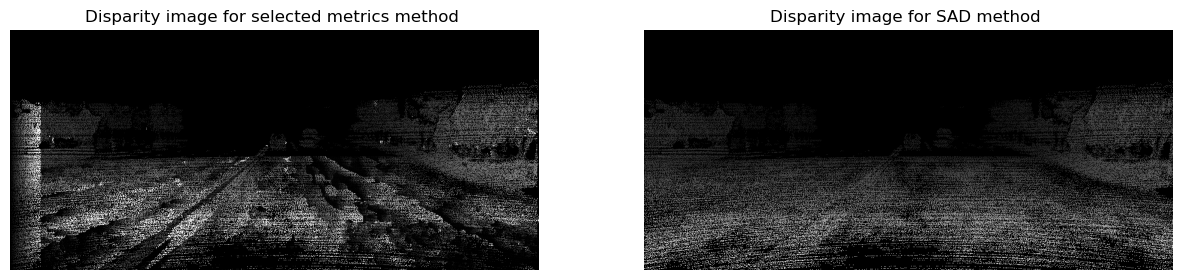

total_rms 17.509566997108276
fraction_four 0.5570341126955496
fraction_two 0.4717693904638737
fraction_one 0.3535150710728426
fraction 0.5 0.21897015280944765
fraction 0.25 0.12096563772703037


In [63]:
similarity_metric = 'SAD'
disparity_image = BM_disparity(BLOCK_SIZE,image_left,image_right,SEARCH_LENGTH,similarity_metric)

zero=np.where(gt_disparity==0)
disparity_image[zero]=0
plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SAD method ')
plt.axis('off')
plt.show()

total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

## SAD (Normalized image)

In [64]:
similarity_metric = 'SAD'
disparity_image = BM_disparity(BLOCK_SIZE,image_left_normalized,image_right_normalized,SEARCH_LENGTH,similarity_metric)

zero=np.where(gt_disparity==0)
disparity_image[zero]=0
plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SAD method ')
plt.axis('off')
plt.show()

total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

NameError: name 'image_left_normalized' is not defined

## NCC

100%|██████████| 400/400 [12:19<00:00,  1.85s/it]


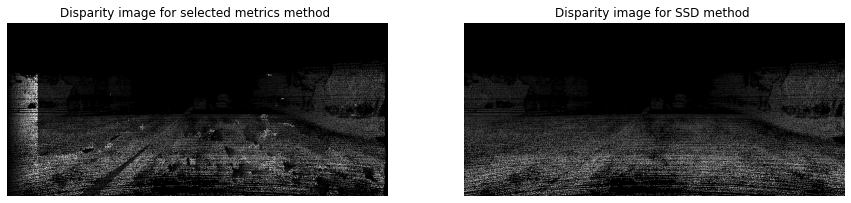

total_rms 13.152245515384914
fraction_four 0.764569081895427
fraction_two 0.6009483941961905
fraction_one 0.40689060567902074
fraction 0.5 0.2407854882074669
fraction 0.25 0.13114158980816573


In [185]:
similarity_metric = 'NCC'
disparity_image = BM_disparity(BLOCK_SIZE,image_left,image_right,SEARCH_LENGTH,similarity_metric)
# bsize = (3, 3)
# disparity_image_blur = cv2.GaussianBlur(disparity_image, bsize,0)
# disparity_image_blur = cv2.medianBlur(disparity_image,5)
disparity_image = same_mask_as_gt(disparity_image,gt_disparity)

# disparity_image = same_mask_as_gt(disparity_image_blur,gt_disparity)
plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SSD method ')
plt.axis('off')
plt.show()
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

# Utilizing kernel doing the convolution

In [6]:
def SAD_conv(kernel,window_size,image_left,image_right):
    row,column = image_left.shape
    disparity_3d=np.zeros((window_size,row,column))
    for i in range(window_size):
        newimage_right=cv2.copyMakeBorder(image_right[:,:column-i],0,0,i,0,cv2.BORDER_REFLECT)
        disparity_3d[i]=cv2.filter2D(np.abs(image_left-newimage_right),-1,kernel)
    min_disparity=np.argmin(disparity_3d,axis=0)
    return min_disparity

def SSD_conv(kernel,window_size,image_left,image_right):
    row,column = image_left.shape
    disparity_3d=np.zeros((window_size,row,column))
    for i in range(window_size):
        newimage_right=cv2.copyMakeBorder(image_right[:,:column-i],0,0,i,0,cv2.BORDER_REFLECT)
        disparity_3d[i]=cv2.filter2D((image_left-newimage_right)**2,-1,kernel)
    min_disparity=np.argmin(disparity_3d,axis=0)
    return min_disparity

def NCC_conv(kernel,window_size,image_left,image_right):
    row,column = image_left.shape
    disparity_3d=np.zeros((window_size,row,column))
    for i in range(window_size):
        # newimage_right=np.roll(image_right,i)
        # newimage_right[:,:i]=image_right[:,:i]
        newimage_right=cv2.copyMakeBorder(image_right[:,:column-i],0,0,i,0,cv2.BORDER_REFLECT)
        disparity_up=image_left*newimage_right
        disparity_down_left=image_left**2
        disparity_down_right=newimage_right**2
        conv_disparity_up=cv2.filter2D(disparity_up,-1,kernel)
        conv_disparity_down_left=cv2.filter2D(disparity_down_left,-1,kernel)
        conv_disparity_down_right=cv2.filter2D(disparity_down_right,-1,kernel)
        conv_disparity=conv_disparity_up/np.sqrt(conv_disparity_down_left*conv_disparity_down_right)
        disparity_3d[i]=conv_disparity
        
    min_disparity=np.argmax(disparity_3d,axis=0)
    return min_disparity

In [358]:
kernel = np.ones((29,29)).astype(np.float32)
window_size=65
# norm_image_left=normalise(image_left)
# norm_image_right=normalise(image_right)
disparity_image = SAD_conv(kernel,window_size,image_left,image_right)
zero=np.where(gt_disparity==0)
disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)

total_rms 15.433635927136612
fraction_four 0.7101044821835756
fraction_two 0.5410498133841564
fraction_one 0.3772703036903425
fraction 0.5 0.2229974248148022
fraction 0.25 0.12089757115792578


In [361]:
%%time
kernel = np.ones((29,29)).astype(np.float32)
window_size=65
# norm_image_left=normalise(image_left)
# norm_image_right=normalise(image_right)
disparity_image = SSD_conv(kernel,window_size,image_left,image_right)
zero=np.where(gt_disparity==0)
disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)

total_rms 15.066136736782507
fraction_four 0.7189871694517238
fraction_two 0.5339482013409114
fraction_one 0.36001542842233036
fraction 0.5 0.20984923254943336
fraction 0.25 0.11065355250768585
CPU times: user 742 ms, sys: 181 ms, total: 923 ms
Wall time: 1.35 s


In [360]:
# apply kernel NCC
kernel = np.ones((27,27)).astype(np.float32)
window_size=67
# image_left=normalise(image_left)
# image_right=normalise(image_right)
disparity_image = NCC_conv(kernel,window_size,image_left,image_right)
zero=np.where(gt_disparity==0)
disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

total_rms 7.706765223309177
fraction_four 0.8683479109235499
fraction_two 0.6422761460708573
fraction_one 0.4270836878467141
fraction 0.5 0.24712702356237734
fraction 0.25 0.13066512382443363


In [294]:
# apply kernel NCC with normalise
kernel = np.ones((27,27)).astype(np.float32)
window_size=67
normimage_left=normalise(image_left)
normimage_right=normalise(image_right)
disparity_image = NCC_conv(kernel,window_size,normimage_left,normimage_right)
zero=np.where(gt_disparity==0)
disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

total_rms 11.215018149431792
fraction_four 0.8217223110869096
fraction_two 0.6096949483261296
fraction_one 0.4063914508389205
fraction 0.5 0.23742753746497408
fraction 0.25 0.12595718612803322


In [301]:
# apply kernel NCC with sharpen
kernel = np.ones((27,27)).astype(np.float32)
window_size=67
sharpimage_left=sharpen(image_left)
sharpimage_right=sharpen(image_right)
disparity_image = NCC_conv(kernel,window_size,sharpimage_left,sharpimage_right)
zero=np.where(gt_disparity==0)
disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

total_rms 12.847045472379984
fraction_four 0.7516704670501083
fraction_two 0.5463816946306821
fraction_one 0.3741619303678998
fraction 0.5 0.22156802686360594
fraction 0.25 0.12162361456170802


In [308]:
# apply kernel NCC with GaussianBlur
kernel = np.ones((27,27)).astype(np.float32)
window_size=67
gau_image_left= cv2.GaussianBlur(image_left,(5,5),0)
gau_image_right= cv2.GaussianBlur(image_right,(5,5),0)

disparity_image = NCC_conv(kernel,window_size,gau_image_left,gau_image_right)
zero=np.where(gt_disparity==0)
disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025) 

total_rms 6.6113969467217215
fraction_four 0.8813713144788937
fraction_two 0.6553789606234898
fraction_one 0.42463329135894906
fraction 0.5 0.2407854882074669
fraction 0.25 0.1260933192662424


In [7]:
kernel = np.ones((27,27)).astype(np.float32)
window_size=67
disparity_image = NCC_conv(kernel,window_size,image_left,image_right)

In [288]:
#smoothing with median blur
median_smooth_disparity_image=signal.medfilt(disparity_image, kernel_size=67)
zero=np.where(gt_disparity==0)
median_smooth_disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(median_smooth_disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  


total_rms 6.520036104064717
fraction_four 0.8938842187659531
fraction_two 0.7273820463079559
fraction_one 0.47951763491361216
fraction 0.5 0.2672860724455184
fraction 0.25 0.13717682560210553


In [315]:
#smoothing with gaussian blur
disparity_image=np.float32(disparity_image)
gau_smooth_disparity_image= cv2.GaussianBlur(disparity_image,(67,67),0)
zero=np.where(gt_disparity==0)
gau_smooth_disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(gau_smooth_disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025) 

total_rms 4.307747122514144
fraction_four 0.9056597352210461
fraction_two 0.7756866215158424
fraction_one 0.5247592145117925
fraction 0.5 0.3041327751874667
fraction 0.25 0.16117029121147147


In [293]:
#bilateralFilter smooth
bi_smooth_disparity_image = cv2.bilateralFilter(disparity_image,67,75,75)
zero=np.where(gt_disparity==0)
bi_smooth_disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(bi_smooth_disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)

total_rms 3.6673307067848375
fraction_four 0.8995450884298177
fraction_two 0.78728062711999
fraction_one 0.5515207205980782
fraction 0.5 0.3118129530681006
fraction 0.25 0.1598089598293798


In [19]:
%%time
# apply kernel NCC with sharpen
kernel = np.ones((27,27)).astype(np.float32)
window_size=67
gau_image_left= cv2.GaussianBlur(image_left,(5,5),0)
gau_image_right= cv2.GaussianBlur(image_right,(5,5),0)
disparity_image = NCC_conv(kernel,window_size,gau_image_left,gau_image_right)
disparity_image=np.float32(disparity_image)
gau_smooth_disparity_image= cv2.GaussianBlur(disparity_image,(67,67),0)
zero=np.where(gt_disparity==0)
gau_smooth_disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(gau_smooth_disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025) 

total_rms 3.333865450896816
fraction_four 0.9240830865920203
fraction_two 0.7940305618895279
fraction_one 0.5339595457690955
fraction 0.5 0.3013647347105469
fraction 0.25 0.16072785851229168
CPU times: user 1.1 s, sys: 79 ms, total: 1.18 s
Wall time: 1.18 s


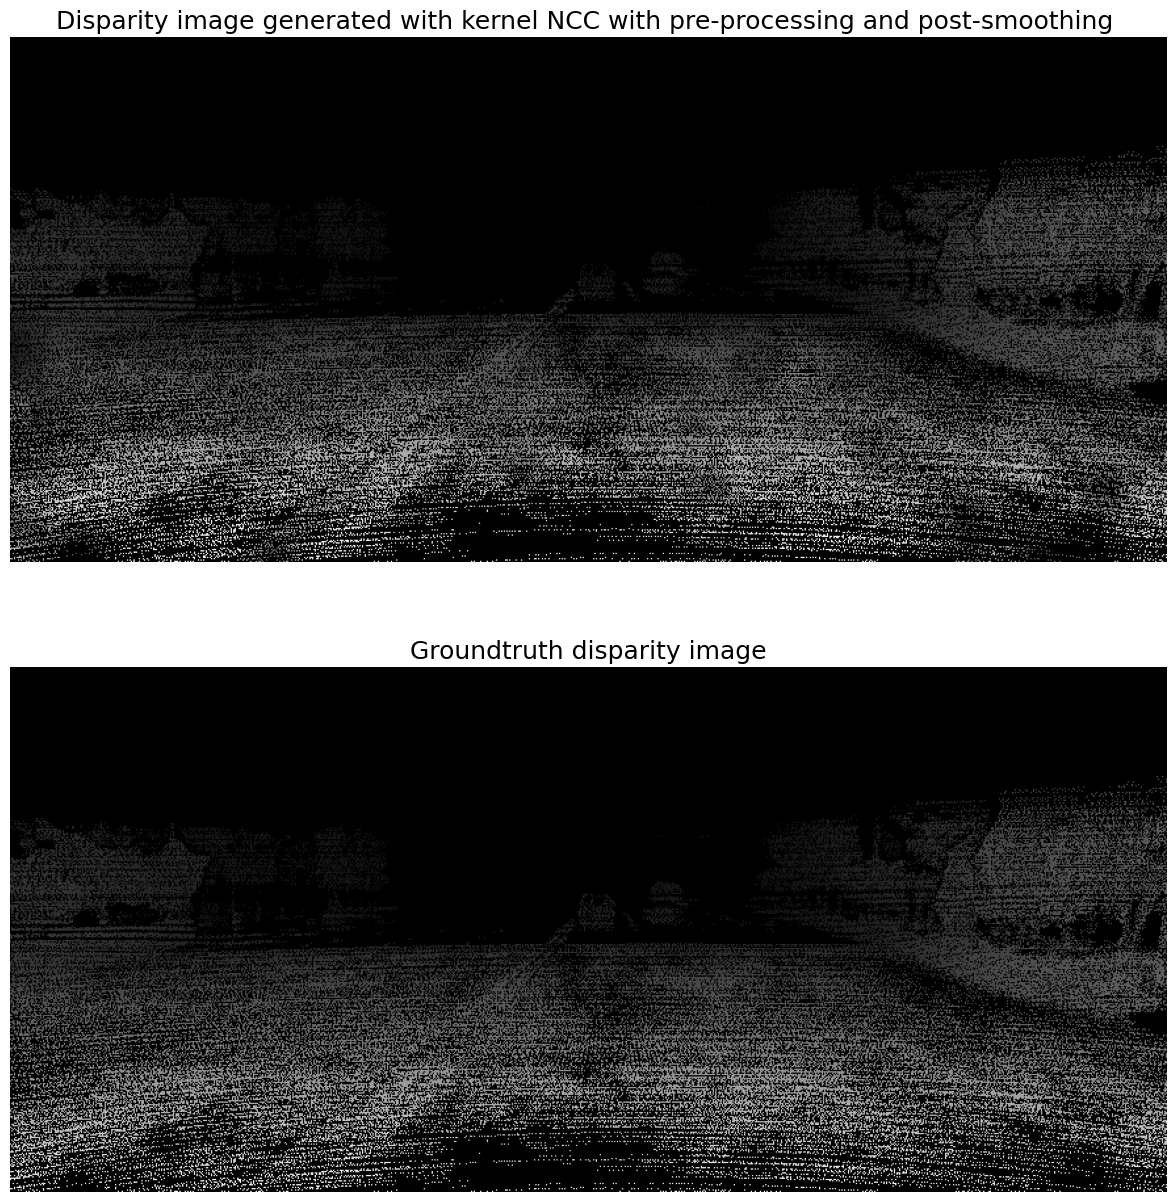

In [9]:
plt.subplots(figsize = (15,15))
plt.subplot(2,1,1)
plt.imshow(gau_smooth_disparity_image,cmap = 'gray')
plt.title('Disparity image generated with kernel NCC with pre-processing and post-smoothing ', fontsize=18)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Groundtruth disparity image',fontsize=18)
plt.axis('off')
plt.show()

In [260]:
# find best Search window size and kernel window size for sad
sad_data=[]
for search_window_size in tqdm(range(1,120)):
    for kernel_size in range(1,50,2):
        kernel = np.ones((kernel_size,kernel_size)).astype(np.float32)
        window_size=search_window_size
        disparity_image = SAD_conv(kernel,window_size,image_left,image_right)
        zero=np.where(gt_disparity==0)
        disparity_image[zero]=0
        total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
        sad_data.append((search_window_size,kernel_size,fraction_four))

100%|██████████| 119/119 [47:35<00:00, 24.00s/it]  


In [261]:
sad_data1=np.array([list(i) for i in sad_data])
sad_data1

array([[  1.        ,   1.        ,   0.        ],
       [  1.        ,   3.        ,   0.        ],
       [  1.        ,   5.        ,   0.        ],
       ...,
       [119.        ,  45.        ,   0.66046126],
       [119.        ,  47.        ,   0.65217983],
       [119.        ,  49.        ,   0.64361479]])

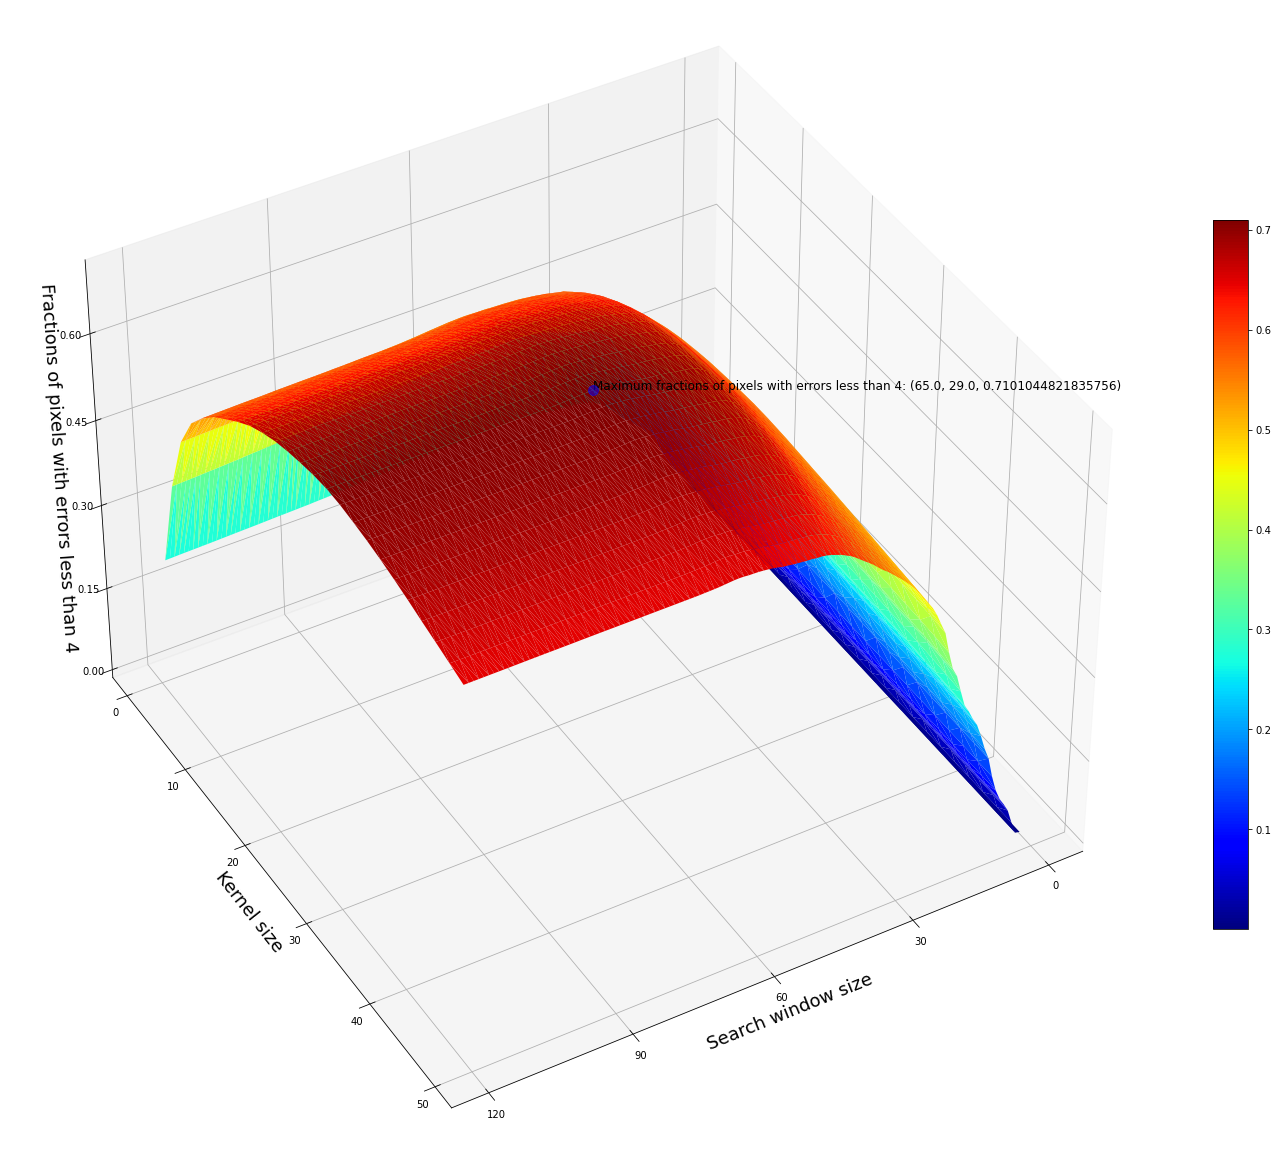

In [267]:
sad_data1=np.array([list(i) for i in sad_data])
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy
from numpy.random import randn
from scipy import array, newaxis
Xs = sad_data1[:,0]
Ys = sad_data1[:,1]
Zs = sad_data1[:,2]
# ======
## plot:
fig = plt.figure(figsize= (20,20))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, zorder=0)
fig.colorbar(surf,shrink = 0.5)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel('Search window size',fontsize=18)
ax.set_ylabel('Kernel size',fontsize=18)
ax.set_zlabel('Fractions of pixels with errors less than 4',fontsize=18)
fig.tight_layout()
# calc index of max Z value
xmax, ymax = Xs[np.argmax(Zs)],Ys[np.argmax(Zs)]
# min max points in 3D space (x,y,z)
mi = (xmax, ymax, Zs.max())
#plot points.
ax.plot(xmax,ymax,Zs.max(),marker="o", markeredgecolor="blue", alpha=0.5,markerfacecolor="blue",markersize=10,zorder=10)
ax.text(xmax,ymax,Zs.max(),f'Maximum fractions of pixels with errors less than 4: {mi}',size=12, color='black')
ax.legend
ax.view_init(40, 60)
plt.show()
# fig.savefig('3D.png')

In [342]:
NCC_fraction_fours=[]

In [343]:
#NCC with equally important pixel kernel
kernel = np.ones((27,27)).astype(np.float32)
window_size=67
for i in range(1,50):
    kernel[14][14]=i
    disparity_image = NCC_conv(kernel,window_size,image_left,image_right)
    zero=np.where(gt_disparity==0)
    disparity_image[zero]=0
    total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
    data=[i,fraction_four]
    NCC_fraction_fours.append(data)


In [344]:
center_pixel = np.array(NCC_fraction_fours)

In [346]:
center_pixel.shape

(49, 2)

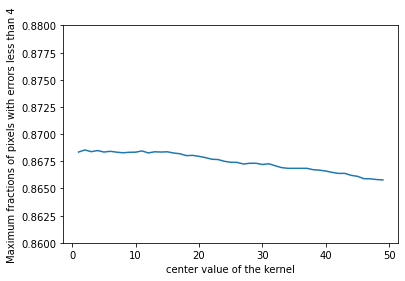

In [351]:
fig = plt.figure()
ax = plt.axes()
x = center_pixel[:,0]
y = center_pixel[:,1]
ax.set_xlabel('center value of the kernel')
ax.set_ylabel('Maximum fractions of pixels with errors less than 4')
ax.plot(x,y)
plt.ylim([0.86,0.88])
plt.show()